In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/ML_Project_B`


In [2]:
using DataFrames
using CSV
using ScikitLearn
using PyPlot

In [3]:
file_path = "Data/framingham.csv"

data = CSV.read(file_path, DataFrame)

data_cleaned = dropmissing(data)

Row,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
,Int64,Int64,String3,Int64,String3,String3,Int64,Int64,Int64,String3,Float64,Float64,String7,String3,String3,Int64
1,1,39,4,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
2,0,46,2,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
3,1,48,1,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
4,0,61,3,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
5,0,46,3,1,23,0,0,0,0,285,130.0,84.0,23.1,85,85,0
6,0,43,2,0,0,0,0,1,0,228,180.0,110.0,30.3,77,99,0
7,0,63,1,0,0,0,0,0,0,205,138.0,71.0,33.11,60,85,1
8,0,45,2,1,20,0,0,0,0,313,100.0,71.0,21.68,79,78,0
9,1,52,1,0,0,0,0,1,0,260,141.5,89.0,26.36,76,79,0


In [4]:
select!(data_cleaned, Not(["education", "cigsPerDay","BPMeds", "totChol", "BMI", "heartRate","glucose"]))

X = Array(data_cleaned[!, Not(:TenYearCHD)])

y = Array(data_cleaned[!, :TenYearCHD])

4238-element Vector{Int64}:
 0
 0
 0
 1
 0
 0
 1
 0
 0
 0
 0
 0
 0
 ⋮
 1
 0
 0
 0
 0
 0
 1
 1
 0
 0
 0
 0

In [5]:
@sk_import model_selection: train_test_split;
X_train, X_test, Y_train, Y_test = 
    train_test_split(X, y, test_size=0.2, 
        random_state=42);

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore ~/.julia/packages/ScikitLearn/sqLdT/src/Skcore.jl:259


In [6]:
@sk_import linear_model: LogisticRegression;
simplelogistic =LogisticRegression(max_iter=1000);

fit!(simplelogistic, X_train, Y_train);

In [7]:
@sk_import metrics: accuracy_score

Y_pred_train = predict(simplelogistic,X_train);
print(accuracy_score(Y_train,Y_pred_train))

0.8492625368731563

In [8]:
@sk_import neural_network: MLPClassifier;
simpleneuralnetwork = MLPClassifier(hidden_layer_sizes=(5));

fit!(simpleneuralnetwork, X_train, Y_train);

Y_pred_train = predict(simpleneuralnetwork,X_train);
print(accuracy_score(Y_train,Y_pred_train))

0.8489675516224189

In [9]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch_logistic = GridSearchCV(LogisticRegression(max_iter=1000),
            Dict(:solver => ["newton-cg", "lbfgs", "liblinear"], 
            :C => [0.01, 0.1, 0.5, 0.9]))

fit!(gridsearch_logistic, X_train, Y_train);

In [10]:
gridsearch_logistic_results = DataFrame(gridsearch_logistic.grid_scores_);
hcat(DataFrame(gridsearch_logistic_results.parameters), 
    gridsearch_logistic_results)[!,Not(:parameters)]

Row,solver,C,mean_validation_score,cv_validation_scores
,String,Float64,Float64,Array…
1,newton-cg,0.01,0.848673,"[0.847922, 0.849558, 0.848539]"
2,lbfgs,0.01,0.848673,"[0.847922, 0.849558, 0.848539]"
3,liblinear,0.01,0.846903,"[0.844385, 0.847788, 0.848539]"
4,newton-cg,0.1,0.848673,"[0.847922, 0.849558, 0.848539]"
5,lbfgs,0.1,0.848673,"[0.847922, 0.849558, 0.848539]"
6,liblinear,0.1,0.847493,"[0.847038, 0.847788, 0.847653]"
7,newton-cg,0.5,0.848968,"[0.84527, 0.852212, 0.849424]"
8,lbfgs,0.5,0.848968,"[0.84527, 0.852212, 0.849424]"
9,liblinear,0.5,0.849558,"[0.84527, 0.852212, 0.851196]"


In [11]:
best_logistic_model = gridsearch_logistic.best_estimator_

PyObject LogisticRegression(C=0.9, max_iter=1000, solver='newton-cg')

In [12]:
gridsearch_neuralnet = GridSearchCV(MLPClassifier(),
            Dict(:solver => ["sgd", "lbfgs", "adam"], 
            :hidden_layer_sizes => [(2), (20), (1,5,10), (10,10), (10,20,10)]))
fit!(gridsearch_neuralnet, X_train, Y_train);


gridsearch_neuralnet_results = DataFrame(gridsearch_neuralnet.grid_scores_);
hcat(DataFrame(gridsearch_neuralnet_results.parameters),
    gridsearch_neuralnet_results)[!,Not(:parameters)]

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum

Row,solver,hidden_layer_sizes,mean_validation_score,cv_validation_scores
,String,Any,Float64,Array…
1,sgd,2,0.846608,"[0.846154, 0.846903, 0.846767]"
2,lbfgs,2,0.847493,"[0.848806, 0.846903, 0.846767]"
3,adam,2,0.846608,"[0.846154, 0.846903, 0.846767]"
4,sgd,20,0.847493,"[0.846154, 0.846903, 0.849424]"
5,lbfgs,20,0.845133,"[0.842617, 0.844248, 0.848539]"
6,adam,20,0.846608,"[0.846154, 0.847788, 0.845881]"
7,sgd,"(1, 5, 10)",0.846018,"[0.844385, 0.846903, 0.846767]"
8,lbfgs,"(1, 5, 10)",0.846608,"[0.846154, 0.846903, 0.846767]"
9,adam,"(1, 5, 10)",0.846608,"[0.843501, 0.846903, 0.849424]"


In [13]:
best_neuralnetwork_model = gridsearch_neuralnet.best_estimator_

PyObject MLPClassifier(hidden_layer_sizes=(10, 20, 10), solver='lbfgs')

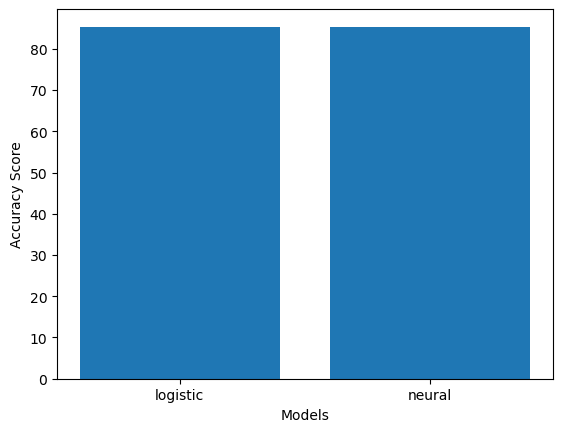

In [14]:
@sk_import metrics: accuracy_score
Y_pred_test_logistic = predict(best_logistic_model, X_test)
logistic_accuracy = accuracy_score(Y_test,Y_pred_test_logistic)

Y_pred_test_neural = predict(best_neuralnetwork_model, X_test)
neural_accuracy = accuracy_score(Y_test,Y_pred_test_neural)

models = ["logistic","neural"]
scores = [logistic_accuracy, neural_accuracy]
# Plotting the results 

using PyPlot  
figure()
b = PyPlot.bar(x = models, height = scores*100);
xlabel("Models"); 
ylabel("Accuracy Score"); 